# Dask at CHTC Demo

We are currently playing with what it takes to spawn Dask workers on the CHTC pool. This notebook (and repository) encapsulate a prototype/demo of doing just that, running from a CHTC submit node and spawning Dask workers in the CHTC pool. We'll do some basic Dask work with CPU workers, then get a few GPU workers and prove we can talk to their GPUs.

Warning! Things will probably go wrong at some point.

This is not ready for production! There's a lot of hacks, and there's a lot of out-of-band system administration going on behind the scenes to make it work for this demo. Do not try this at home... but please get in contact with me (Josh Karpel) or Brian Bockelman if you're interested!

In [ ]:
%matplotlib inline

## Creating a Cluster and Client

Dask is a Python library for flexible parallel computing. It is *flexible* in two ways:
- It supports both low-level and high-level parallelism, and anywhere in-between. In this demo, we'll see examples along that entire spectrum.
- User code generally does not need to change much when the size/shape of the Dask cluster you are connected to changes.

Our first order of business is to create a "cluster" to manage worker jobs on the pool. We feed the cluster to a "client", which is an object that we can use to ask Dask to do work. Many operations on Dask-provided objects, like data arrays, implicitly use the client to do work.

In [ ]:
import dask
from dask_chtc import CHTCCluster
from dask.distributed import Client

WORKER_IMAGE = "maventree/dask-worker:demo"

In [3]:
cluster = CHTCCluster(worker_image = WORKER_IMAGE)
cluster.scale(10)
cluster

HTCondorCluster('tcp://128.104.100.44:3500', workers=0, threads=0, memory=0 B)

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://128.104.100.44:3500 Dashboard: http://128.104.100.44:3400/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Low-Level Parallelism

Dask is capable of parallelizing low-level operations on arrays. All we need to tell Dask is how big the smallest "chunk" of the array it should operate on is. Dask will perform operations on individual chunks out on the workers.

In [5]:
import dask
import dask.array as da

In [6]:
x = da.ones((15, 15), chunks=5)

In [7]:
y = x + x.T
y

dask.array<add, shape=(15, 15), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

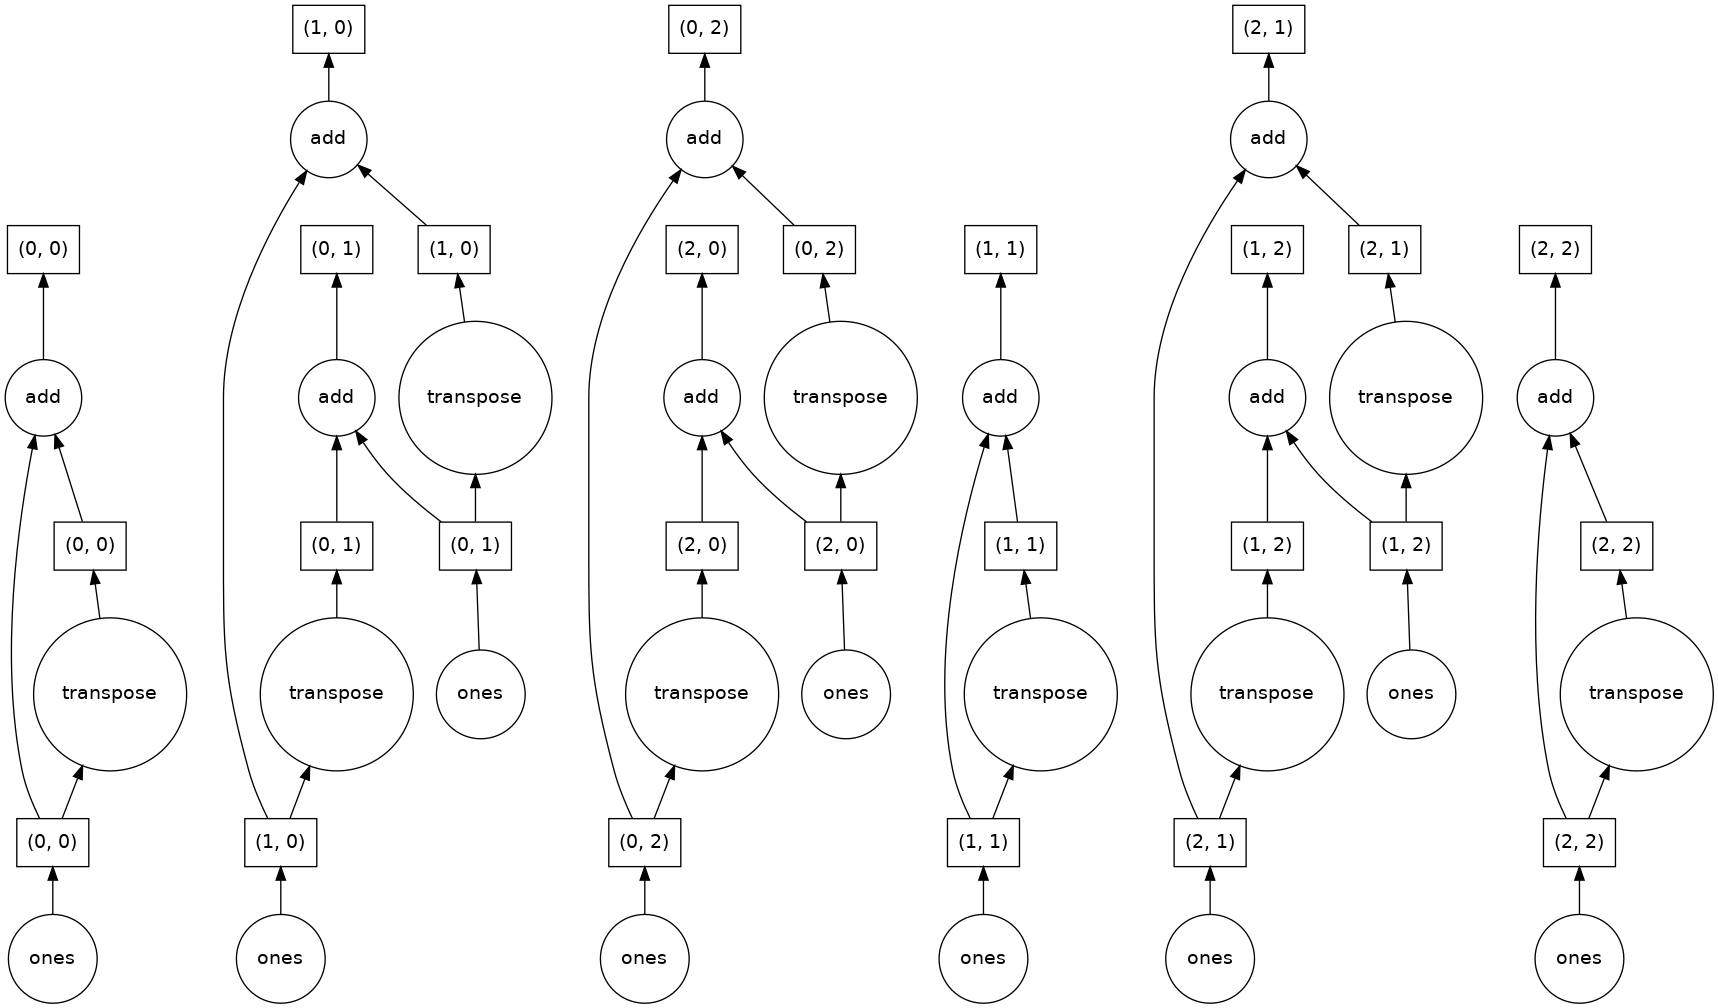

In [8]:
y.visualize()

Note that whoever wrote Dask's transpose algorithm has realized that the chunks along the diagonal don't need to know about any other chunks, while the off-diagonal chunks do. Dask has figured out an efficient workflow automatically, without you needing to be clever yourself.

In [9]:
z = y.compute()
z

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2.

Dask implicitly does this kind of work by overriding normal operations on arrays, as well as implementing most of the `numpy` interface. It has equivalents of pandas dataframes as well. Most of the time, you can write "natural" scientific Python code, and Dask will handle the parallelization.

In [10]:
x = da.random.random((10000, 10000), chunks=1000)
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [11]:
y = ((x ** 2) + 1).sum()
y

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [12]:
z = y.compute()
z

133332268.59520708

This scales up to big operations as well. For example, Dask provides an implemention of SVD, built on top of its other functionality. This combines many operations and has a much more complex task graph, but you don't need to know any of that - just call `svd`! If you need to do other operations on the inputs or results, Dask will join them all together into one big task graph.

In [13]:
x = da.ones((10000, 1000), chunks=(1000, 1000))
u, s, v = da.linalg.svd(x)

In [14]:
s

dask.array<getitem-4798a4ec87dddb42e52eedd266ec9837, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

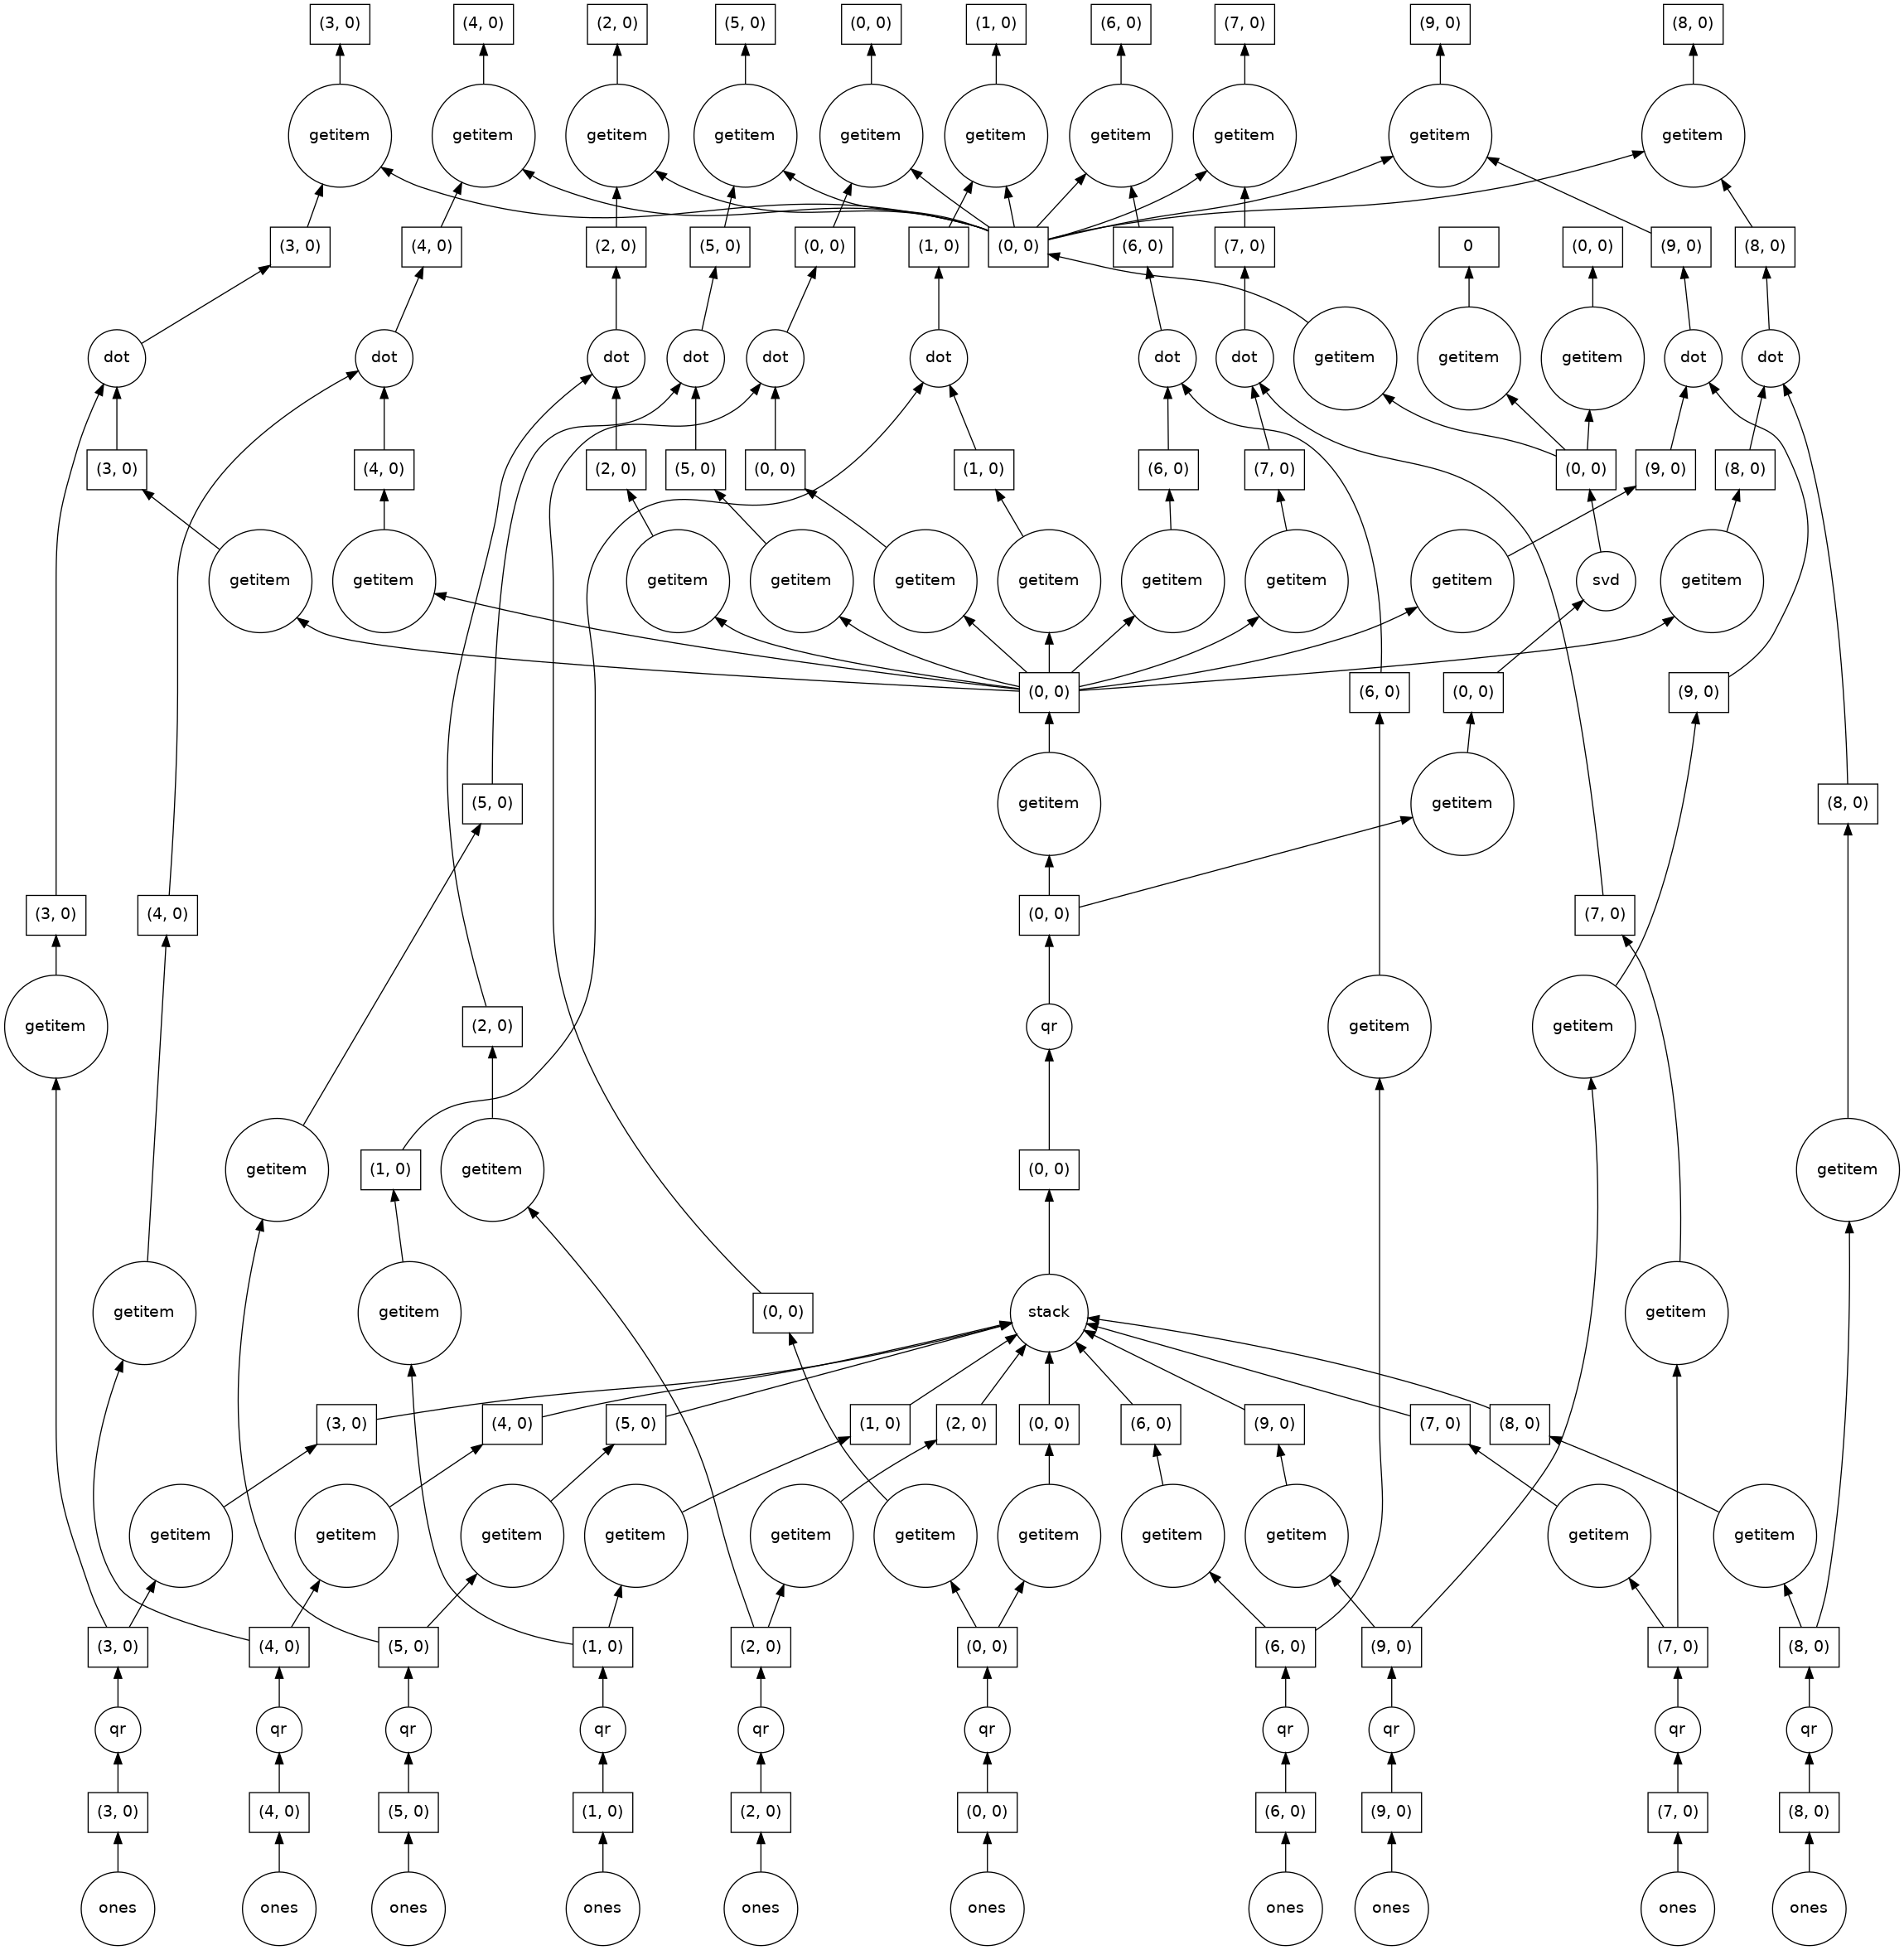

In [15]:
s.visualize()

In [16]:
u, s, v = dask.compute(u, s, v)

## Machine Learning and High-Level Parallelism

Dask-ML provides Dask-based implemenations of various tools commonly used in ML, like clustering:

In [17]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [18]:
X, y = dask_ml.datasets.make_blobs(
    n_samples=10_000_000,
    chunks=1_000_000,
    centers=5,
    center_box=(-10, 10),
    random_state=11
)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

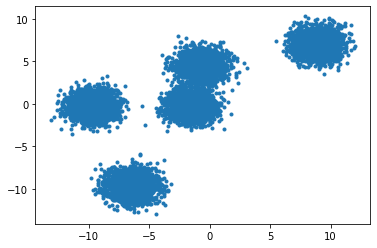

In [19]:
DENSITY = 1000

fig, ax = plt.subplots()
ax.scatter(X[::DENSITY, 0], X[::DENSITY, 1], 
           marker='.');

In [20]:
km = dask_ml.cluster.KMeans(n_clusters=5, init_max_iter=2, oversampling_factor=10)
km

KMeans(init_max_iter=2, n_clusters=5, oversampling_factor=10)

In [21]:
km.fit(X)

KMeans(init_max_iter=2, n_clusters=5, oversampling_factor=10)

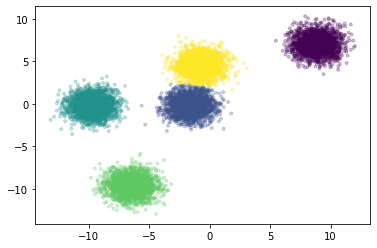

In [22]:
fig, ax = plt.subplots()
ax.scatter(X[::DENSITY, 0], X[::DENSITY, 1], 
           marker='.', 
           c=km.labels_[::DENSITY],
           cmap='viridis', alpha=0.25);

In [23]:
client.cancel(X)

It also has equivalents of scikit-learn's hyperparameter optimization tools... as well as some fancier ones, like Scott Sievert's hyperband implementation! (https://examples.dask.org/machine-learning/hyperparam-opt.html)

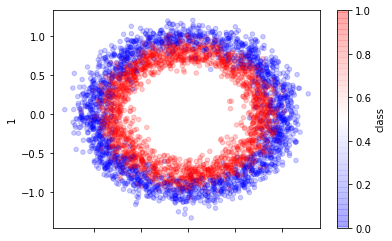

In [24]:
from demo import make_hyperparameter_optimization_problem

X, y = make_hyperparameter_optimization_problem()

In [25]:
from demo import make_train_test

X_train, X_test, y_train, y_test = make_train_test(X, y)

In [26]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),
    "batch_size": [16, 32, 64, 128, 256, 512],
}

In [32]:
n_examples = 15 * len(X_train)
n_params = 15

max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees

X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train, chunks=chunks)
X_train2

dask.array<array, shape=(45000, 6), dtype=float64, chunksize=(45000, 6), chunktype=numpy.ndarray>

In [33]:
from dask_ml.model_selection import HyperbandSearchCV

search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,
)
search

HyperbandSearchCV(estimator=MLPClassifier(), max_iter=15,
                  parameters={'activation': ['relu', 'logistic', 'tanh'],
                              'alpha': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517796e-06, 1.04236067e-06, 1.04959323e-06,
       1.05687597e-06, 1.06420924e-06, 1.07159340e-06, 1.07902879e-06,
       1.08651577e-06, 1.09405471e-06, 1.10164595e-06, 1....
       9.01477631e-04, 9.07732653e-04, 9.14031075e-04, 9.20373200e-04,
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181e-04, 1.00000000e-03]),
                              'batch_size': [16, 32, 64, 128, 256, 512],
                              'hidden_layer_sizes': [(24,), (12, 12),
                                                     (6, 6, 6, 6),
                                                     (4, 4,

In [34]:
search.fit(X_train2, y_train2, classes=[0, 1, 2, 3])

HyperbandSearchCV(estimator=MLPClassifier(), max_iter=15,
                  parameters={'activation': ['relu', 'logistic', 'tanh'],
                              'alpha': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517796e-06, 1.04236067e-06, 1.04959323e-06,
       1.05687597e-06, 1.06420924e-06, 1.07159340e-06, 1.07902879e-06,
       1.08651577e-06, 1.09405471e-06, 1.10164595e-06, 1....
       9.01477631e-04, 9.07732653e-04, 9.14031075e-04, 9.20373200e-04,
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181e-04, 1.00000000e-03]),
                              'batch_size': [16, 32, 64, 128, 256, 512],
                              'hidden_layer_sizes': [(24,), (12, 12),
                                                     (6, 6, 6, 6),
                                                     (4, 4,

In [35]:
search.best_estimator_

MLPClassifier(activation='tanh', alpha=0.000128264983052806, batch_size=16,
              hidden_layer_sizes=(12, 12))

Dask-ML does not provide its own model description language. Instead, it can work with anything obeying the scikit-learn API, namely scikit-learn itself and PyTorch with the Skorch wrapper layer, which we'll see in the final example.

## GPUs

In [ ]:
client.shutdown()

In [ ]:
cluster = CHTCCluster(worker_image = WORKER_IMAGE, gpus = True)
cluster.scale(2)

client = Client(cluster)
client

In [ ]:
import socket
import torch
import os

def probe():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        has_gpu = True
    else:
        device = torch.device('cpu')
        has_gpu = False
        
    return (socket.gethostname(), has_gpu, device)

probe()

In [ ]:
client.run(probe)

In [ ]:
def tensor_addition():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    a = torch.tensor([1., 2.], device = device)
    
    a.add(1.0)
    
    a = a.cpu()
    
    return a

In [ ]:
dask.delayed(tensor_addition)().compute()

### Training a PyTorch model on GPUs

PyTorch -> Skorch -> Dask-ML

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    iterator_train__shuffle=True,
    device="cuda",
)
net

In [ ]:
from dask_ml.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}

gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

In [ ]:
gs.fit(X, y)

In [ ]:
gs.cv_results_